In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

Load Fashion MNIST Dataset

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#x_train = x_train[..., tf.newaxis]   # normally x_train.shape is (60000, 28, 28), with adding tf.newaxis we get x_train.shape as (60000, 28, 28, 1)
#x_test = x_test[..., tf.newaxis]     # normally x_test.shape is (60000, 28, 28), with adding tf.newaxis we get x_test.shape as (60000, 28, 28, 1)

x_train = tf.cast(tf.reshape(x_train, shape=(60000, 784)), tf.float32)
x_test = tf.cast(tf.reshape(x_test, shape=(10000, 784)), tf.float32)

print(x_train.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 784)


In [3]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

In [18]:
from tensorflow.keras import layers

class Autoencoder(tf.keras.Model):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self.activity_reg = tf.keras.regularizers.L1(LEARNING_RATE)
        self.autoencoder_model = self.autoencoder()
        '''
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")
        '''
    def call(self, x):
        #super().call()
        return self.autoencoder_model(x)

    def autoencoder(self):
        input_layer = Input(shape=self._input_shape, name="input_layer")
        # Encoder Part
        x = Dense (784, activation="relu", activity_regularizer=self.activity_reg)(input_layer)
        x = Dense (256, activation="relu",activity_regularizer=self.activity_reg)(x)
        x = Dense (128, activation="relu", activity_regularizer=self.activity_reg)(x)
        # Latent vector layer
        x = Dense (self.latent_dim, activation="relu", activity_regularizer=self.activity_reg)(x)
        embed = tf.keras.layers.Flatten()(x)

        # Decoder Part
        x = Dense(128, activation="relu", activity_regularizer=self.activity_reg)(embed)
        x = Dense(256, activation="relu", activity_regularizer=self.activity_reg)(x)
        x = Dense(784, activation="relu", activity_regularizer=self.activity_reg)(x)
        # Output Layer
        decoder_out = Dense(self._input_shape[0], activation="sigmoid", activity_regularizer=self.activity_reg)(x)
        autoencoder_model = tf.keras.models.Model(input_layer, decoder_out, name="autoencoder")
        autoencoder_model.summary()
        return autoencoder_model

    def compute_loss(self, y_true, y_pred):
        # Implement your custom loss function here
        # Example: Mean Squared Error (MSE)
        return tf.reduce_mean(tf.square(y_true - y_pred))
    '''
    def compile(self, optimizer, loss, metrics):
        super().compile()
        self.ae_optimizer = optimizer
        self.loss_fn = loss
        self.metrics = metrics
    '''
    '''
    @property
    #def metrics(self):
    #    # We list our `Metric` objects here so that `reset_states()` can be
    #    # called automatically at the start of each epoch
    #    # or at the start of `evaluate()`.
    #    # If you don't implement this property, you have to call
    #    # `reset_states()` yourself at the time of your choosing.
    #    return [self.loss_tracker, self.mae_metric]
    '''
    def train_step(self, data):
        # x, y = data
        x, _ = data  # In autoencoders, the input and output are usually the same.

        # Train the autoencoder
        with tf.GradientTape() as tape:
            y_pred = self.autoencoder_model(x, training=True)
            #ae_loss = self.loss_fn(y, y_pred)
            # The loss function is configured in `compile()`.
            #ae_loss = self.compute_loss(y, y_pred)
            ae_loss = self.compute_loss(y_true=x, y_pred=y_pred)

        # Compute gradients
        grads = tape.gradient(ae_loss, self.autoencoder_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.autoencoder_model.trainable_weights))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(ae_loss)
            else:
                metric.update_state(x, y_pred)

        # Print the loss every 20 steps (adjust as needed)
        #if self.optimizer.iterations % 20 == 0:
        #  print(f"Step {self.optimizer.iterations}, Loss: {ae_loss}")

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        metric_dict = {m.name: m.result() for m in self.metrics}
        metric_dict["ae_loss"] = ae_loss
        return metric_dict

    def test_step(self, data):
        # Unpack the data
        #x, y = data
        x, _ = data  # In autoencoders, the input and output are usually the same.

        # Compute predictions
        y_pred = self.autoencoder_model(x, training=False)
        # Updates the metrics tracking the loss
        self.compute_loss(y_true=x, y_pred=y_pred)

        # Update the metrics.
        for metric in self.metrics:
            if metric.name != "loss":
                metric.update_state(x, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [20]:
autoencoder_model = Autoencoder(input_shape=(x_train.shape[1],), latent_dim=64)

# Compile the model
autoencoder_model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.mean_squared_error])

# Train the model on the MNIST dataset
autoencoder_model_hist = autoencoder_model.fit(x_train, x_train, batch_size=32, epochs=5, validation_data=(x_test, x_test))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 dense_72 (Dense)            (None, 784)               615440    
                                                                 
 dense_73 (Dense)            (None, 256)               200960    
                                                                 
 dense_74 (Dense)            (None, 128)               32896     
                                                                 
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 128)               

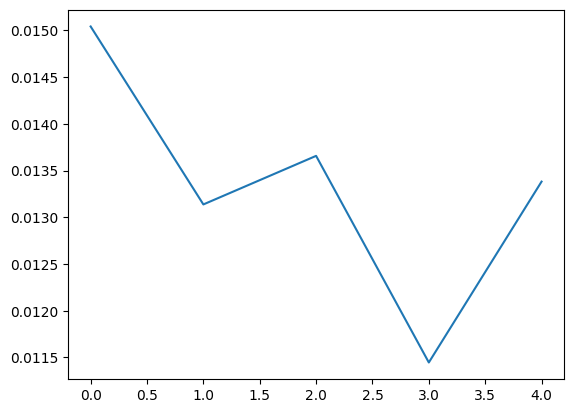

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(autoencoder_model_hist.history))

In [23]:
# Evaluate the model on the test set
results = autoencoder_model(x_test)

In [24]:
results = tf.reshape(results, shape=(results.shape[0], 28, 28))

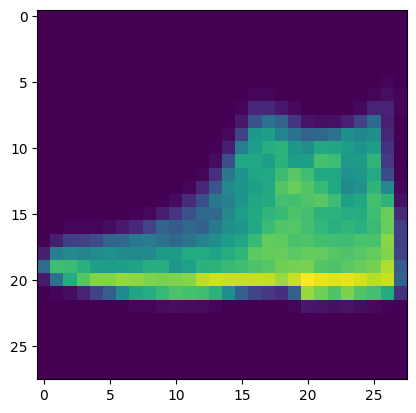

In [25]:
plt.imshow(results[0])

In [ ]:
autoencoder_2_input = autoencoder_model.predict(x_train)

1875/1875 [==============================] - 6s 3ms/step


In [ ]:
autoencoder_2_input = np.concatenate((autoencoder_2_input, x_train))

In [ ]:
autoencoder_model_2 = Autoencoder(input_shape=(autoencoder_2_input.shape[1],), latent_dim=64)

# Compile the model
autoencoder_model_2.compile(optimizer='adam',
              loss='mse',
              metrics=['loss'])

# Train the model on the MNIST dataset
autoencoder_model_2.fit(autoencoder_2_input, autoencoder_2_input, batch_size=32, epochs=5, validation_data=(x_test, x_test))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 784)               615440    
                                                                 
 dense_25 (Dense)            (None, 256)               200960    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 128)               

In [ ]:
autoencoder_3_input = autoencoder_model_2.predict(autoencoder_2_input)
autoencoder_3_input = np.concatenate((autoencoder_3_input, autoencoder_2_input))

autoencoder_model_3 = Autoencoder(input_shape=(autoencoder_3_input.shape[1],), latent_dim=64)


# Compile the model
autoencoder_model_3.compile(optimizer='adam',
              loss='mse',
              metrics=['loss'])

satck_3 = autoencoder_model_3.fit(autoencoder_3_input, autoencoder_3_input, epochs=5, batch_size=16)

3750/3750 [==============================] - 10s 3ms/step
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784)]             0         
                                                                 
 dense_40 (Dense)            (None, 784)               615440    
                                                                 
 dense_41 (Dense)            (None, 256)               200960    
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                               

In [ ]:
test_images = autoencoder_model_3(x_test)

In [ ]:
test_images = tf.reshape(test_images, shape=(test_images.shape[0], 28, 28))

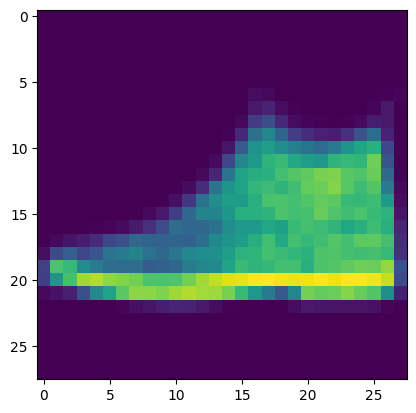

In [ ]:
plt.imshow(test_images[0])

Reference:

https://towardsdatascience.com/stacked-autoencoders-f0a4391ae282